In [2]:
import sys
sys.path.append('/lhome/dylanb/astronomy/MCMC_main/MCMC_main')
sys.path.append('/lhome/dylanb/astronomy/jet_accretion/jet_accretion')
import argparse
import numpy as np
import matplotlib.pylab as plt
import scipy
from scipy.constants import *
from scipy import integrate
from sympy import mpmath as mp
import ionisation_excitation as ie
import radiative_transfer as rt
import pickle
import Cone
import geometry_binary
from radiative_transfer import *
from astropy import units as u

#"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#   ============================================================================
#   We first initialise the spectral line properties, input data (spectra),
#   orbital parameters, and jet parameters that we need to calculate the
#   absorption by the jet.
#   Next, create the post-AGB star (as a Fibonacci-grid), the binary system and
#   the jet configuration.
#   We then calculate the amount of absorption by the jet in the spectral line,
#   and its equivalent width and compare it with the observations.
#   ============================================================================
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

"""
==================================================
Command line input
==================================================
"""
# args = sys.argv

# parser = argparse.ArgumentParser()

# parser.add_argument('-o', dest='object_id',
#                     help='Object identifier')
# parser.add_argument('-l', dest='line', help='The spectral line')

# args          = parser.parse_args()
# object_id     = args.object_id
# spectral_line = args.line

object_id = 'IRAS19135+3937'
spectral_line = 'halpha'

In [3]:

"""
#==================================================
#Balmer line properties (ionisation and excitation)
#==================================================
"""

###### Hydrogen properties #####################################################
E_ionisation_H      = np.array([13.6, 0]) # ionisation energy in eV
E_levels_H          = {1: np.array([0, 10.2, 12.1, 12.76]), 2: np.array([0])} # (eV) energy levels of all excitation states for each ionisation level
degeneracy_H        = {1: np.array([2, 8, 18, 32]), 2: np.array([1])} # Degeneracy of the excitation states

###### Balmer properties, i.e., einstein coefficients for Halpha, Hbeta, #######
###### Hgamma, and Hdelta ######################################################

wave_0 = {'halpha': 6562.8e-10, 'hbeta': 4861.35e-10, 'hgamma': 4340.47e-10,\
         'hdelta': 4101.73e-10}
# B_lu = np.array([4.568e14, 6.167e14, 6.907e14, 7.309e14])
B_lu = np.array([1.6842e+21]) # from wikipedia
line = 'halpha'



In [88]:


"""
#================================
#Binary system and jet properties
#================================
"""
AU              = 1.496e+11     # 1AU in m
AU_to_km        = 1.496e+08     # 1AU in km
days_to_sec     = 24*60*60      # 1day in seconds
degr_to_rad     = np.pi/180    # Degrees to radians
###### Read in the object specific and model parameters ########################
parameters = {}
with open('../jet_accretion/input_data/'+str(object_id)+'/'+str(object_id)+'.dat') as f:
    lines  = f.readlines()[2:]

for l in lines:
    split_lines       = l.split()
    title             = split_lines[0]
    value             = split_lines[1]
    parameters[title] = value

###### Wavelength ##############################################################
central_wavelength  = eval(parameters['w_c_'+str(line)])        # (angstrom)
w_begin             = eval(parameters['w_begin_'+str(line)])    # (angstrom)
w_end               = eval(parameters['w_end_'+str(line)])      # (angstrom)
###### Binary system and stellar parameters ####################################
omega               = eval(parameters['omega'])    # Argument of periastron (degrees)
ecc                 = eval(parameters['ecc'])      # Eccentricity
T0                  = eval(parameters['T0'])       # Time of periastron (days)
period              = eval(parameters['period'])   # period (days)
primary_asini       = eval(parameters['asini'])    # asini of the primary (AU)
primary_rad_vel     = eval(parameters['K_p'])      # Radial velocity primary (km s^-1)
primary_sma_a1      = eval(parameters['R_p'])      # SMA of the primary (a1)
primary_mass        = eval(parameters['m_p'])	   # mass primary (M_sol)
primary_Teff        = eval(parameters['T_eff'])    # Surface temperature of the primary (K)
mass_function       = eval(parameters['fm'])       # mass function (AU)
angular_frequency   = 2. * np.pi / period          # angular frequency (days^-1)
gridpoints_LOS      = eval(parameters['points_pathlength']) # number of points along the path length trough the jet
gridpoints_primary  = eval(parameters['points_primary'])    # number of points on the primary star
###### Jet model solution parameters ###########################################
jet_type            = parameters['jet_type']               # None
inclination         = eval(parameters['incl']) * degr_to_rad     # radians
jet_angle           = eval(parameters['alp']) * degr_to_rad      # radians
const_optical_depth = eval(parameters['const_optical_depth'])    # None
velocity_centre     = eval(parameters['velocity_centre'])        # km s^-1
velocity_edge       = eval(parameters['velocity_edge'])          # km s^-1
primary_radius_a1   = eval(parameters['radius_primary_a1'])      # a1
primary_radius_au   = eval(parameters['radius_primary_au'])      # AU
power_density       = eval(parameters['c_den'])                  # None
power_velocity      = eval(parameters['c_vel'])                  # None
###### Binary system and stellar parameters from jet solution ##################
primary_sma_AU      = primary_asini / np.sin(inclination) # SMA of the primary (AU)
primary_max_vel     = primary_rad_vel / np.sin(inclination) # Orbital velocity (km/s)
secondary_mass      = geometry_binary.calc_mass_sec(primary_mass, inclination, mass_function) # (AU)
mass_ratio          = primary_mass / secondary_mass       # None
secondary_sma_AU    = primary_sma_AU * mass_ratio         # SMA of the secondary (AU)
secondary_rad_vel   = primary_rad_vel * mass_ratio        # Radial velocity secondary (km/s)
secondary_max_vel   = primary_max_vel * mass_ratio        # Orbital velocity secondary (km/s)
T_inf               = geometry_binary.T0_to_IC(omega, ecc, period, T0)

print(T_inf)

2454945.27609


In [89]:
"""
===============
Stellar spectra
===============
"""

###### Observed spectra, background spectra, and wavelength region #############
spectrum_test = '416105'
phase_test    = 45
with open('../jet_accretion/input_data/'+object_id+'/'+object_id+'_observed_'+line+'.txt', 'rb') as f:
    spectra_observed    = pickle.load(f)
with open('../jet_accretion/input_data/'+object_id+'/'+object_id+'_wavelength_'+line+'.txt', 'rb') as f:
    spectra_wavelengths = pickle.load(f)
with open('../jet_accretion/input_data/'+object_id+'/'+object_id+'_init_'+line+'.txt', 'rb') as f:
    spectra_background  = pickle.load(f)
phases = list()
spectra = list()
for ph in spectra_observed.keys():
    phases.append(ph)
    for spectrum in spectra_observed[ph].keys():
        spectra.append(spectrum)

print(phases)
print(spectra)
###### uncertainty on the data #################################################

standard_deviation = {}
with open('../jet_accretion/input_data/'+object_id+'/'+object_id+'_signal_to_noise_'+str(line)+'.txt', 'rb') as f:
    signal_to_noise = pickle.load(f)
with open('../jet_accretion/input_data/'+object_id+'/'+object_id+'_stdev_init_'+str(line)+'.txt', 'rb') as f:
    uncertainty_background = pickle.load(f)

for ph in uncertainty_background:
    standard_deviation[ph] = {}
    for spectrum in uncertainty_background[ph]:
        standard_deviation[ph][spectrum] = \
                    2./signal_to_noise[spectrum] + uncertainty_background[ph][spectrum]

###### Cut the wavelength region if necessary ##################################

wavmin = min(range(len(spectra_wavelengths)), key = lambda j: abs(spectra_wavelengths[j]- w_begin))
wavmax = min(range(len(spectra_wavelengths)), key = lambda j: abs(spectra_wavelengths[j]- w_end))
spectra_wavelengths = spectra_wavelengths[wavmin:wavmax]

for ph in spectra_observed:
    for spectrum in spectra_observed[ph]:
        spectra_observed[ph][spectrum]   = spectra_observed[ph][spectrum][wavmin:wavmax]
        spectra_background[ph][spectrum] = spectra_background[ph][spectrum][wavmin:wavmax]
        standard_deviation[ph][spectrum] = standard_deviation[ph][spectrum][wavmin:wavmax]


[11, 14, 22, 25, 30, 37, 38, 40, 42, 43, 45, 49, 53, 56, 60, 68, 70, 74, 82, 94, 98, 99]
['412254', '412470', '413299', '395745', '414226', '415391', '397189', '415686', '399553', '415971', '416105', '416578', '417170', '403024', '418187', '419147', '419301', '406609', '421031', '410256', '410862', '411001']


In [90]:

"""
=======================
Create the binary orbit
=======================
"""
primary_orbit = {}
secondary_orbit = {}
for ph in phases:
    prim_pos, sec_pos, prim_vel, sec_vel = geometry_binary.pos_vel_primary_secondary(ph, period,
                                           omega, ecc, primary_sma_AU,
                                           secondary_sma_AU, T_inf, T0)
    primary_orbit[ph]               = {}
    secondary_orbit[ph]             = {}
    primary_orbit[ph]['position']   = prim_pos
    primary_orbit[ph]['velocity']   = prim_vel
    secondary_orbit[ph]['position'] = sec_pos
    secondary_orbit[ph]['velocity'] = sec_vel



In [139]:

"""
==========================================
Create post-AGB star with a Fibonacci grid
==========================================
"""
print(inclination)
import Star
postAGB = Star.Star(primary_radius_au, primary_orbit[phase_test]['position'], inclination, gridpoints_primary)
postAGB._set_grid()
postAGB._set_grid_location()

1.3753194505715316


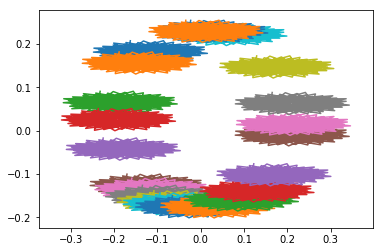

In [140]:
for loc in primary_orbit:
    postAGB.centre = primary_orbit[loc]['position']
    postAGB._set_grid_location()
    plt.plot(postAGB.grid_location[:,0], postAGB.grid_location[:,1])
plt.axis('equal')
plt.show()

In [141]:
"""
==============
Create the jet
==============
"""
import importlib
importlib.reload(Cone)
jet = Cone.Stellar_jet_simple(inclination,
                             jet_angle,
                             velocity_centre,
                             velocity_edge,
                             jet_type, jet_centre=secondary_orbit[phase_test]['position'])
jet._set_gridpoints(primary_orbit[phase_test]['position'], gridpoints_LOS)
jet._set_gridpoints_unit_vector()
jet._set_gridpoints_polar_angle()

[ 0.02750796  0.24574232  0.        ]


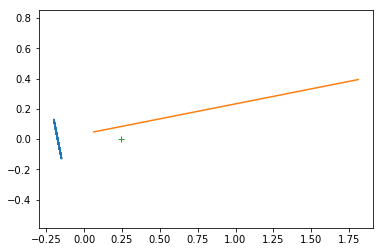

In [142]:
postAGB.centre = primary_orbit[phase_test]['position']
postAGB._set_grid_location()
plt.plot(postAGB.grid_location[:,1], postAGB.grid_location[:,2])
plt.plot(jet.gridpoints[:,1],jet.gridpoints[:,2])
plt.plot(jet.jet_centre[1], jet.jet_centre[2], '+')
print(jet.jet_centre)
# for i in range(np.arange(0,0.2,0.01)):
    
plt.axis('equal')
plt.show()


In [150]:
"""
===========================
Jet temperature and density
===========================
"""

jet_temperature = 4000      # The jet temperature (K)
jet_density_max = 1e18      # The jet number density at its outer edge (m^-3)
jet_density_scaled = jet.density(gridpoints_LOS, power_density)

jet_velocity    = jet.poloidal_velocity(gridpoints_LOS, power_velocity)

jet_density        = jet_density_scaled*jet.gridpoints[:,2]*jet_density_max
print(jet_density)


[ 75.9         57.26707654  29.40140181  45.79088323  57.88912463
  63.82583326  67.20157491  69.35424026  70.84001619  71.925025
  72.75126334  73.40104127  73.92523573  74.35693951  74.71858668
  75.02591445  75.29028367  75.52009869  75.72170895  75.9       ]


[  2.11512687e+19   1.60399598e+18   6.05884771e+15   1.72269260e+17
   9.53603325e+17   1.80831336e+18   2.41344143e+18   2.78227510e+18
   2.98538537e+18   3.08071039e+18   3.10753069e+18   3.09125276e+18
   3.04817130e+18   2.98877635e+18   2.91986719e+18   2.84587743e+18
   2.76970722e+18   2.69325106e+18   2.61773699e+18   2.54394736e+18]
[ 0.04727849  0.06547909  0.08367969  0.10188029  0.12008089  0.13828149
  0.15648209  0.17468269  0.19288329  0.21108389  0.22928449  0.24748509
  0.26568569  0.28388629  0.30208689  0.32028749  0.33848809  0.35668869
  0.37488929  0.39308989]
0.9906
